In [193]:
import new_feature_extraction as nfe
from new_feature_extraction import read_data
from new_feature_extraction import read_logistic_data
from new_feature_extraction import read_buy_rating_data
from new_feature_extraction import get_all_stocks_df
from new_feature_extraction import get_stock_df
from new_feature_extraction import featurize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'last_expr'

In [195]:
# df = get_stock_df("/Users/rithikpothuganti/cs467/csci467-project/data/uis.csv")
df = get_all_stocks_df()

In [196]:
from sklearn.model_selection import train_test_split

features = ['r_90d', 'r_180d', 'r_1y', 'r_2y', 'r_5y', 'r_10y']
# features = ['r_15d', 'r_30d', 'r_90d', 'r_180d', 'r_1y', 'r_2y', 'r_5y', 'r_10y']
# features = ['r_15d', 'r_30d', 'r_90d', 'r_180d', 'r_1y']
label = ['target_return', 'label', 'Date', 'Close/Last', 'rating']

X = df[features]
X.fillna(0, inplace=True)
y = df[label]

# Define the split indices
train_split_idx = int(len(X) * 0.5)
dev_split_idx = int(len(X) * 0.75)

# Train split
X_train_df, y_train_df = X.iloc[:train_split_idx], y.iloc[:train_split_idx]
train_dates = df["Date"].iloc[:train_split_idx]

# Dev (validation) split
X_dev_df, y_dev_df = X.iloc[train_split_idx:dev_split_idx], y.iloc[train_split_idx:dev_split_idx]
dev_dates = df["Date"].iloc[train_split_idx:dev_split_idx]

# Test split
X_test_df, y_test_df = X.iloc[dev_split_idx:], y.iloc[dev_split_idx:]
test_dates = df["Date"].iloc[dev_split_idx:]

# Combine dev and test sets
X_combined = pd.concat([X_dev_df, X_test_df], axis=0)
y_combined = pd.concat([y_dev_df, y_test_df], axis=0)
combined_dates = pd.concat([dev_dates, test_dates], axis=0)

# Shuffle combined dev and test sets
# X_dev, X_test, y_dev, y_test, dev_dates, test_dates = train_test_split(
#     X_combined, y_combined, combined_dates, test_size=len(y_test_df) / len(y_combined), shuffle=True
# )

dev_dates.head(10)


/var/folders/ps/hbp83zj53cb60mmc6jt7f2s00000gn/T/ipykernel_6227/3718641654.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


1258   2018-03-12
1259   2018-03-13
1260   2018-03-14
1261   2018-03-15
1262   2018-03-16
1263   2018-03-19
1264   2018-03-20
1265   2018-03-21
1266   2018-03-22
1267   2018-03-23
Name: Date, dtype: datetime64[ns]

In [197]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
DEGREE = 1
X_train, y_train = read_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

linreg_model = LinearRegression()
reg = linreg_model.fit(X_train, y_train)  # Train the model
y_pred = linreg_model.predict(X_dev)
mse = mean_squared_error(y_dev, y_pred)
print("MSE:", mse)


MSE: 0.3131076375755096


In [198]:
# softmax regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = X_train
X_dev_scaled = X_dev

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
softmax_reg.fit(X_train_scaled, y_train)  # Train the model
w = softmax_reg.coef_.flatten()  # Weight vector

def evaluate(model, X, y, name):
    preds = model.predict(X)  # vector of size n
    acc = np.mean(preds == y)
    print(f'{name} accuracy: ', acc)

evaluate(softmax_reg, X_dev_scaled, y_dev, "softmax regression, dev")


softmax regression, dev accuracy:  0.39243027888446214


In [199]:
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

evaluate(softmax_reg, X_test, y_test, "softmax regression, test")

softmax regression, test accuracy:  0.14940239043824702


In [200]:
# Neural Network

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class ReturnPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReturnPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.bn5 = nn.BatchNorm1d(hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.bn6 = nn.BatchNorm1d(hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.tanh(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = torch.tanh(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.fc7(x)
        x = F.softmax(x, dim=1)
        return x


In [201]:
DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)
# X_train = scaler.fit_transform(X_train)
# X_dev = scaler.transform(X_dev)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
# X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
# y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32).view(-1, 1)
# # stats_2023_tensor = torch.tensor(stats_2023_values, dtype=torch.float32).to('cpu')

# # Create DataLoader objects
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=256, shuffle=False)

# test_data = TensorDataset(X_dev_tensor, y_dev_tensor)
# dev_loader = DataLoader(test_data, batch_size=256, shuffle=False)



In [202]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
output_size = 5  # Number of classes
num_epochs = 70
batch_size = 128
learning_rate = 0.00001

# Convert data to tensors and create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

dev_dataset = TensorDataset(torch.tensor(X_dev, dtype=torch.float32), torch.tensor(y_dev, dtype=torch.long))
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
model = ReturnPredictor(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [1/70], Loss: 1.6140
Validation Accuracy: 10.36%
Epoch [2/70], Loss: 1.6122
Validation Accuracy: 10.36%
Epoch [3/70], Loss: 1.6113
Validation Accuracy: 7.37%
Epoch [4/70], Loss: 1.6141
Validation Accuracy: 7.37%
Epoch [5/70], Loss: 1.6109
Validation Accuracy: 7.37%
Epoch [6/70], Loss: 1.6144
Validation Accuracy: 7.37%
Epoch [7/70], Loss: 1.6097
Validation Accuracy: 7.37%
Epoch [8/70], Loss: 1.6098
Validation Accuracy: 7.37%
Epoch [9/70], Loss: 1.6078
Validation Accuracy: 7.37%
Epoch [10/70], Loss: 1.6062
Validation Accuracy: 7.37%
Epoch [11/70], Loss: 1.6107
Validation Accuracy: 7.37%
Epoch [12/70], Loss: 1.6041
Validation Accuracy: 7.37%
Epoch [13/70], Loss: 1.6066
Validation Accuracy: 7.37%
Epoch [14/70], Loss: 1.6020
Validation Accuracy: 7.37%
Epoch [15/70], Loss: 1.6068
Validation Accuracy: 7.37%
Epoch [16/70], Loss: 1.6043
Validation Accuracy: 7.37%
Epoch [17/70], Loss: 1.6022
Validation Accuracy: 7.37%
Epoch [18/70], Loss: 1.6042
Validation Accuracy: 7.37%
Epoch [19/70], Lo

In [203]:
# Neural network test accuracy
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 12.15%


In [204]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


DEGREE = 10
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

# Create the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=100, min_samples_leaf=10, max_features='auto', bootstrap=True)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_dev)

# Calculate the accuracy
accuracy = accuracy_score(y_dev, y_pred) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 45.22%


/Users/rithikpothuganti/cs467/csci467-project/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [205]:
# Random Forest Test Accuracy
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
print(np.sum(y_pred == 0))
print(len(y_pred))

Test Accuracy: 14.54%
460
502


In [206]:
# K nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

DEGREE = 1
X_train, y_train = read_buy_rating_data(X_train_df, y_train_df)
X_train = featurize(X_train, d=DEGREE)
X_dev, y_dev = read_buy_rating_data(X_dev_df, y_dev_df)
X_dev = featurize(X_dev, d=DEGREE)

knn = KNeighborsClassifier(n_neighbors=250)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_dev)

accuracy_knn = accuracy_score(y_dev, y_pred)
print(f"Validation Accuracy: {accuracy_knn:.4f}")

Validation Accuracy: 0.5797


In [207]:
X_test, y_test = read_buy_rating_data(X_test_df, y_test_df)
X_test = featurize(X_test, d=DEGREE)

y_pred = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy_knn:.4f}")

Test Accuracy: 0.1992


In [289]:
# Recurrent neural network
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
# Make sure to replace 'your_data.csv' with the actual path to your dataset
data = get_stock_df("/Users/rithikpothuganti/cs467/csci467-project/data/uis.csv")
prices = data['Close/Last'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
prices_norm = scaler.fit_transform(prices)

# Create sequences
sequence_length = 60

def create_sequences(data, seq_length):
    sequences = []
    target = []

    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        target.append(data[i + seq_length])

    return np.array(sequences), np.array(target)

sequences, targets = create_sequences(prices_norm, sequence_length)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences).float()
test_sequences = torch.tensor(test_sequences).float()
train_targets = torch.tensor(train_targets).float()
test_targets = torch.tensor(test_targets).float()

# Create DataLoader
train_data = TensorDataset(train_sequences, train_targets)
test_data = TensorDataset(test_sequences, test_targets)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define RNN model
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPredictor, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

# Model parameters
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1

# Instantiate the model
model = StockPredictor(input_dim, hidden_dim, num_layers, output_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 100

for epoch in range(num_epochs):
    for i, (sequences, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

KeyError: 'Close'

In [288]:
# Testing
model.eval()
test_predictions = []
with torch.no_grad():
    for sequences, targets in test_loader:
        outputs = model(sequences)
        test_predictions.append(outputs.numpy())

# Convert to numpy array and reshape
test_predictions = np.concatenate(test_predictions, axis=0)
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
print('Test RMSE: %.3f' % rmse)

# Plot predictions vs. targets
import matplotlib.pyplot as plt
plt.plot(test_targets, label='True')
plt.plot(test_predictions, label='Predicted')
plt.legend()
plt.show()


AttributeError: 'ARIMA' object has no attribute 'eval'

In [286]:
# Testing
model.eval()
with torch.no_grad():
    # Use the last `sequence_length` values in the test set as input
    last_sequence = test_sequences[-1:]
    predicted_prices = []
    for i in range(days_into_future):
        # Use the model to make a prediction for the next day
        predicted = model(last_sequence).numpy()
        predicted_prices.append(predicted[0][0])

        # Update the input sequence with the predicted value
        last_sequence = torch.tensor(np.append(last_sequence[:, 1:, :], predicted, axis=1)).float()

# Convert to numpy array and reshape
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Create arrays for x-axis labels
test_dates = data['Date'].values[-len(test_targets):]
next_year_dates = pd.date_range(test_dates[-1], periods=days_into_future+1, freq='d')[1:]

# Plot predictions vs. targets
import matplotlib.pyplot as plt
plt.plot(test_dates, test_targets, label='True')
plt.plot(test_dates, scaler.inverse_transform(model(test_sequences).numpy()), label='Predicted')
plt.plot(next_year_dates, predicted_prices, label='Next Year')
plt.legend()
plt.show()


AttributeError: 'ARIMA' object has no attribute 'eval'

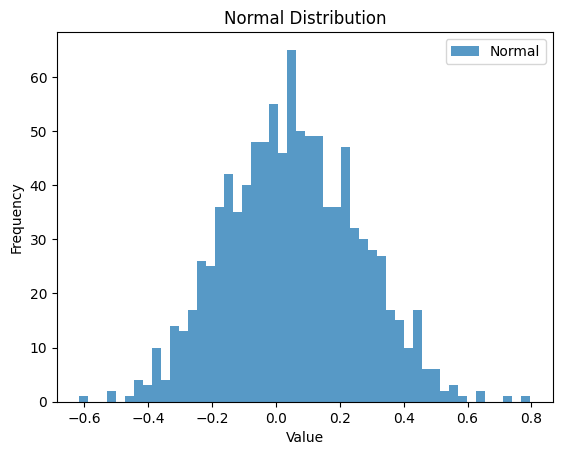

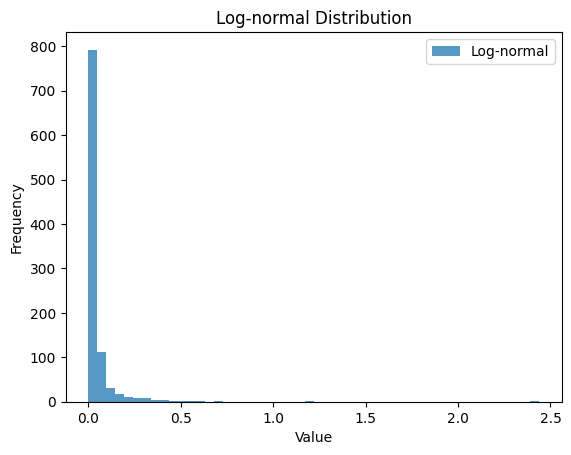

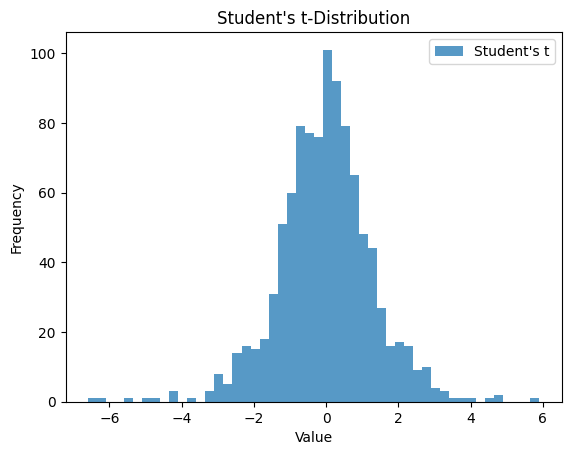

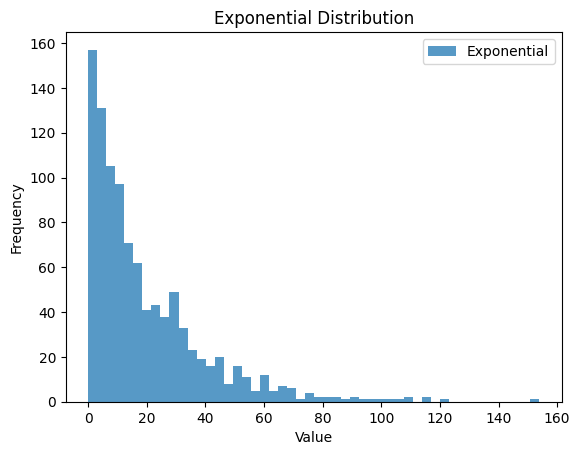

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Normal distribution
mean = 0.05
std_dev = 0.2
num_samples = 1000

normal_samples = np.random.normal(loc=mean, scale=std_dev, size=num_samples)

plt.hist(normal_samples, bins=50, alpha=0.75, label='Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Normal Distribution')
plt.legend()
plt.show()

# Log-normal distribution
mu = np.log(mean**2 / np.sqrt(mean**2 + std_dev**2))
sigma = np.sqrt(np.log(1 + std_dev**2 / mean**2))

lognormal_samples = np.random.lognormal(mean=mu, sigma=sigma, size=num_samples)

plt.hist(lognormal_samples, bins=50, alpha=0.75, label='Log-normal')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log-normal Distribution')
plt.legend()
plt.show()

# Student's t-distribution
df = 5

t_samples = np.random.standard_t(df, size=num_samples)

plt.hist(t_samples, bins=50, alpha=0.75, label="Student's t")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title("Student's t-Distribution")
plt.legend()
plt.show()

# Exponential distribution
scale = 1 / mean

exponential_samples = np.random.exponential(scale=scale, size=num_samples)

plt.hist(exponential_samples, bins=50, alpha=0.75, label='Exponential')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Exponential Distribution')
plt.legend()
plt.show()
